# load data 

## write trump and biden speeches to one file 

In [66]:
## Preparing the dataset

import os
import pandas as pd
import re

text = ""


for filename in os.listdir("Biden_speeches"):
    path = "Biden_speeches/"+filename
    with open(path) as f:
        t = f.read()
        t = re.sub(r"\[.*\]", '', t)
        t = t.replace("”",'"')
        t = t.replace("“",'"')
        t = t.replace("’","'")
        t = re.sub(r"\\", '', t)
        text += t


with open("other_speeches.txt", "w", encoding = 'utf-8') as file1:
    # Writing data to a file
    file1.write(text)

# data prep 

In [1]:
with open("trump_speeches.txt", encoding = "utf-8") as f:
    trump = f.read()

with open("other_speeches.txt", encoding = "utf-8") as f:
    others = f.read()

In [84]:
def splitToSentences(text, minwords):
    sentences = []
    too_short_save = ""

    dot_split = text.split(".")

    mem_words = 0
    for i in dot_split:
        words = i.split(" ")
        if (len(words) + mem_words) < minwords: 
            too_short_save = too_short_save + ". " + i
            mem_words = mem_words + len(words)
        else:
            too_short_save = too_short_save + ". " + i + ". "
            sentences.append(too_short_save[2:])
            mem_words = 0
            too_short_save = ""
    return(sentences)

In [88]:
trumpSentenceList = splitToSentences(trump, 100)
OtherSentenceList = splitToSentences(others, 100)

lets take first 50000 words for classifier

In [2]:
trump_classifier = trump.split(" ")[:50000]
trump_generator = trump.split(" ")[50000:]
others_words = others.split(" ")[:50000]
others_test_words = others.split(" ")[50000:]

In [5]:
trump_classifier_string = " ".join(trump_classifier)
trump_generator_string = " ".join(trump_generator)
others_words_string = " ".join(others_words)
others_valid_string = " ".join(others_test_words)

In [101]:
trumpSentenceList = splitToSentences(trump_generator_string, 100)

In [110]:
trumpValidationSentenceList = trumpSentenceList[:int(len(trumpSentenceList) * 0.1)]
trumpGeneratorSentenceList = trumpSentenceList[int(len(trumpSentenceList) * 0.1):]

In [124]:
trumpGeneratorText = "".join(trumpGeneratorSentenceList)
trumpValidationText = "".join(trumpValidationSentenceList)

- trumpGeneratorText.txt: 2885 sentences with more than 100 words, 314485 words
- trumpValidationText.txt: 320 sentences with more than 100 words, 34845 words
- trumpClassifierText.txt: 509 sentences with more than 100 words, 50000 words 
- othersClassifierText.txt: 475 sentences with more than 100 words, 50000 words

 write data to txt that in different runs data wouldnt mix 

In [128]:
with open("data_splits/trumpGeneratorText.txt", "w", encoding = 'utf-8') as file1:
    # Writing data to a file
    file1.write(trumpGeneratorText)
    
with open("data_splits/trumpValidationText.txt", "w", encoding = 'utf-8') as file1:
    # Writing data to a file
    file1.write(trumpValidationText)
    
with open("data_splits/trumpClassifierText.txt", "w", encoding = 'utf-8') as file1:
    # Writing data to a file
    file1.write(trump_classifier_string)
    

In [6]:
with open("data_splits/othersTestText.txt", "w", encoding = 'utf-8') as file1:
    # Writing data to a file
    file1.write(others_valid_string)

# Metrics 

## read data 

In [2]:
with open("data_splits/trumpGeneratorText.txt", encoding = "utf-8") as f:
    trumpGeneratorText = f.read()

with open("data_splits/trumpTestText.txt", encoding = "utf-8") as f:
    trumpValidationText = f.read()
    
with open("data_splits/trumpClassifierText.txt", encoding = "utf-8") as f:
    trump_classifier_string = f.read()

with open("data_splits/othersClassifierText.txt", encoding = "utf-8") as f:
    others_words_string = f.read()

first test BLEU score, text will be divided into snipets with equal amount of words to avoid brevity penalty. We need to avoid it as its its not a tranlation task so penalyzing for different sentence lenght would give us more information. 


In [3]:
def makeChunks(text, size):
    our_list = text.split(" ")
    chunked_list = list()
    chunk_size = size
    for i in range(0, len(our_list), chunk_size):
        chunked_list.append(our_list[i:i+chunk_size])
    return(chunked_list[:-1]) # not to take last one as it might be not the size as asked

trumpValidationText will be ours reference, trump_classifier_string candidate

In [4]:
reference = makeChunks(trumpValidationText, 100)
candidate1 = makeChunks(trump_classifier_string, 100)
candidate2 = makeChunks(others_words_string, 100)

In [5]:
from nltk.translate.bleu_score import sentence_bleu
from scipy.stats import ttest_ind

C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Ttest_indResult(statistic=15.87934260048414, pvalue=2.2547916197719586e-49)


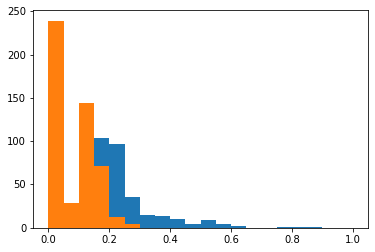

In [6]:
import matplotlib.pyplot as plt

results1 = [sentence_bleu(reference, i,weights = (0.25,0.25,0.25,0.25)) for i in candidate1]
results2 = [sentence_bleu(reference, i,weights = (0.25,0.25,0.25,0.25)) for i in candidate2]

res = ttest_ind(results1, results2, equal_var = False)
print(res)
plt.hist(results1, bins = 20, range = (0,1))
plt.hist(results2, bins = 20, range = (0,1))
plt.show()

In [7]:
## lets try to make <M> bleu 

import spacy
import en_core_web_sm

def unnameTextWithM(text):
    nlp = en_core_web_sm.load()
    doc = nlp(text)
    text = text
    for ent in reversed(doc.ents):
        text = text[:ent.start_char] + "<M>" + text[ent.end_char:] 
    return text

In [8]:
reference = makeChunks(unnameTextWithM(trumpValidationText), 100)
candidate1 = makeChunks(unnameTextWithM(trump_classifier_string), 100)
candidate2 = makeChunks(unnameTextWithM(others_words_string), 100)

In [9]:
import matplotlib.pyplot as plt

C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Ttest_indResult(statistic=14.856654552421134, pvalue=3.922902184025463e-44)


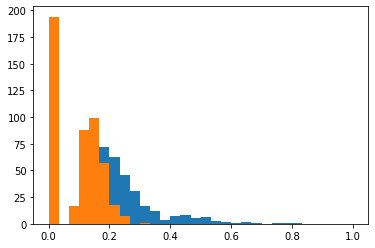

In [10]:
results1 = [sentence_bleu(reference, i,weights = (0.25,0.25,0.25,0.25)) for i in candidate1]
results2 = [sentence_bleu(reference, i,weights = (0.25,0.25,0.25,0.25)) for i in candidate2]

res = ttest_ind(results1, results2, equal_var = False)
print(res)
plt.hist(results1, bins = 30, range = (0,1))
plt.hist(results2, bins = 30, range = (0,1))
plt.show()

## lets check classifiers and how much they are correlated with BLEU scores 

In [11]:
import dill as pickle


objectRep = open("classifiers/POSclassifier4.obj", "rb")
POSclassiefier = pickle.load(objectRep)
objectRep.close()
 
objectRep = open("classifiers/Textclassifier.obj", "rb")
Textclassifier = pickle.load(objectRep)
objectRep.close()


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
Posclassifier = POSclassiefier()
Posclassifier.predict(["<|endoftext|> of our American … And they coming to be more police.   That's where he has been incredible.   He'll be honest with you.   It'll be honest.   And then I tell you, and we're going to do.   We'll do it.   We're going to have a lot of big, but we're going to make a lot of bad things done long time.   We're going to have your children, but we're going to take things done.   We're going to love that happen it.   We're going to do this country.  "])

array([[0.2046865, 0.7953135]], dtype=float32)

In [13]:
Textclassifier.predict_proba(["Thank you, Thank you Great America"])

array([[0.31582377, 0.68417623]])

In [14]:
trump_sentences = [" ".join(listc) for listc in candidate1]
others_sentences = [" ".join(listc) for listc in candidate2]

In [15]:
import numpy as np
blue1 = np.concatenate((results1, results2), axis = 0)

In [16]:
all_sentences = trump_sentences + others_sentences

In [17]:
PosCls = Posclassifier.predict(all_sentences)

In [18]:
print(
        np.corrcoef(PosCls[:,1], blue1)[0,1]
     )

0.2107291251238099


In [19]:
TextCls = Textclassifier.predict_proba(all_sentences)

In [20]:
print(
        np.corrcoef(TextCls[:,1], blue1)[0,1]
     )


0.4335583129853304


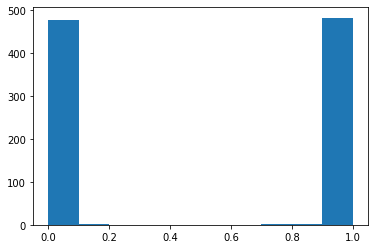

In [21]:
plt.hist(TextCls[:,1])
plt.show()

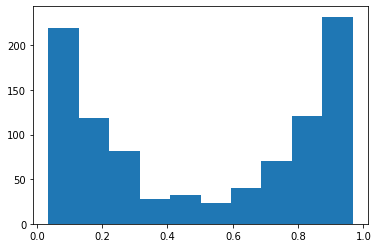

In [22]:
plt.hist(PosCls[:,1])
plt.show()